# Analysis 1
In this document, a first attempt at compiling the analysis into a clear and coherrent structure, with both code and prose to explain and contextualize the results

In [1]:
# Load in packages
# imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go
import json
from typing import List, Any, Dict, Tuple, Optional
from IPython.display import display
from helper_functions import clean_data_age_gender, split_csv, calculate_household_stats

#Future proofing of the way we use pandas
pd.options.mode.copy_on_write = True

# Set the path to the data
census_dir_path = Path().cwd().parent / 'data' / 'census'
path_to_combined_data = census_dir_path / 'combined_data_raw.csv'
df_raw = pd.read_csv(path_to_combined_data)

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_4385/2424092919.py:20: DtypeWarning: Columns (2,3,4,7,9,10,11,12,13,14,15,18,19,20,21,22,23,24,26,27,28,29,30,31,44,47,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(path_to_combined_data)


## Section 0: pre-processing
In this section, the cleaned data will be enhanced by adding additional information. Specifically, i will code the data with:

In [2]:
# add classification of urban and rural
urban_parishes = ['aarhus købstad', 'sankt annæ øster kvarter', 'sankt annæ vester kvarter', 'christianshavn kvarter']

df_raw['area_type'] = df_raw['parish'].apply(lambda x: 'urban' if x in urban_parishes else 'rural')

In [3]:
parish_list = df_raw['parish'].unique()

## Section 1: Marriage age
In this section, i will explore the age of marriage for women, based on geography, wheter they live in a urban/non-urban parish and age

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_4385/2698296566.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amt_data.groupby(groupby_cols)


<Figure size 4000x2000 with 0 Axes>

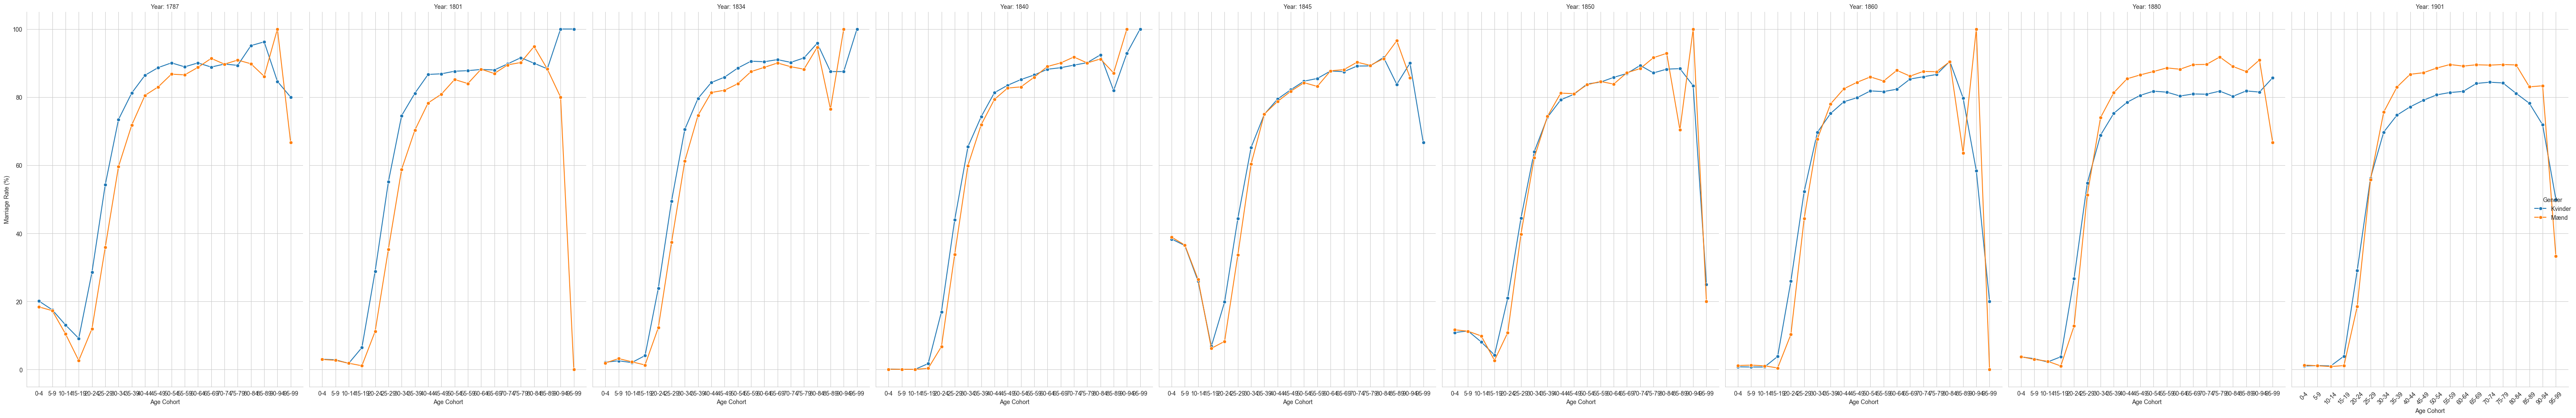

In [4]:
def create_age_cohorts(
    data: pd.DataFrame,
    bin_size: int = 5
) -> pd.DataFrame:
    """
    Create age cohorts in the dataset.
    
    Args:
        data: DataFrame containing the census data
        bin_size: Size of age cohorts in years (default: 5)
        
    Returns:
        DataFrame with new age_cohort column
    """
    df = data.copy()
    df['age_cohort'] = pd.cut(
        df['age_full_years'],
        bins=range(0, 101, bin_size),
        labels=[f'{i}-{i+bin_size-1}' for i in range(0, 100, bin_size)]
    )
    return df

def calculate_marriage_rates(
    data: pd.DataFrame,
    amt: str,
    urban_parishes: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Calculate marriage rates by age cohort, gender, and year for a specific amt.
    
    Args:
        data: DataFrame containing the census data with age_cohort column
        amt: The amt to analyze
        urban_parishes: Optional list of parishes to be considered urban
        
    Returns:
        DataFrame with marriage rates by age cohort, gender, year, and area type
    """
    amt_data = data[data['amt'] == amt].copy()
    
    # Add area type classification
    if urban_parishes and len(urban_parishes) > 0:
        amt_data['area_type'] = np.where(
            amt_data['parish'].isin(urban_parishes),
            'Urban',
            'rural'
        )
    else:
        amt_data['area_type'] = 'Overall'
    
    # Calculate marriage rates
    groupby_cols = ['age_cohort', 'sex', 'year']
    if amt_data['area_type'].nunique() > 1:
        groupby_cols.append('area_type')
    
    marriage_rates = (
        amt_data.groupby(groupby_cols)
        .agg({
            'marital_status': lambda x: (x != 'Ugift').mean() * 100
        })
        .reset_index()
        .rename(columns={'marital_status': 'marriage_rate'})
    )
    
    # Ensure consistent gender labeling
    gender_mapping = {
        'k': 'Kvinder',
        'm': 'Mænd'
    }
    marriage_rates['sex'] = marriage_rates['sex'].map(gender_mapping)
    
    return marriage_rates

def plot_temporal_marriage_distribution(
    marriage_rates: pd.DataFrame,
    amt: str,
    plot_type: str = 'age_cohorts',
    specific_ages: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (40, 20)
) -> None:
    """
    Plot temporal marriage distribution with multiple visualization options.
    
    Args:
        marriage_rates: DataFrame with marriage rates
        amt: The amt being plotted
        plot_type: Type of plot ('age_cohorts', 'heatmap', or 'selected_ages')
        specific_ages: Optional list of age cohorts to plot (for 'selected_ages')
        figsize: Figure size as tuple (width, height)
    """
    sns.set_style("whitegrid")
    has_areas = 'area_type' in marriage_rates.columns and marriage_rates['area_type'].nunique() > 1
    
    if plot_type == 'heatmap':
        # Create heatmap for each gender and area type
        unique_areas = marriage_rates['area_type'].unique()
        fig, axes = plt.subplots(
            len(unique_areas),
            2,
            figsize=figsize,
            gridspec_kw={'hspace': 0.4}
        )
        
        for i, area in enumerate(unique_areas):
            area_data = marriage_rates[marriage_rates['area_type'] == area]
            
            for j, gender in enumerate(['Kvinder', 'Mænd']):
                gender_data = area_data[area_data['sex'] == gender]
                pivot_data = gender_data.pivot(
                    index='age_cohort',
                    columns='year',
                    values='marriage_rate'
                )
                
                ax = axes[i][j] if len(unique_areas) > 1 else axes[j]
                sns.heatmap(
                    pivot_data,
                    cmap='YlOrRd',
                    ax=ax,
                    cbar_kws={'label': 'Marriage Rate (%)'}
                )
                ax.set_title(f'{gender} - {area}')
                ax.set_xlabel('Year')
                ax.set_ylabel('Age Cohort')
    
    elif plot_type == 'selected_ages':
        if not specific_ages:
            specific_ages = ['20-24', '25-29', '30-34']
        
        plt.figure(figsize=figsize)
        
        filtered_data = marriage_rates[marriage_rates['age_cohort'].isin(specific_ages)]
        
        if has_areas:
            g = sns.FacetGrid(
                filtered_data,
                col='area_type',
                row='sex',
                height=figsize[1]/2,
                aspect=figsize[0]/figsize[1]
            )
            g.map_dataframe(
                sns.lineplot,
                x='year',
                y='marriage_rate',
                hue='age_cohort',
                marker='o'
            )
            g.add_legend(title='Age Cohort')
            g.set_axis_labels('Year', 'Marriage Rate (%)')
            g.set_titles('{row_name} - {col_name}')
        else:
            sns.lineplot(
                data=filtered_data,
                x='year',
                y='marriage_rate',
                hue='age_cohort',
                style='sex',
                markers=True,
                dashes=False
            )
            plt.title(f'Marriage Rates Over Time for Selected Age Cohorts in {amt.capitalize()}')
            plt.xlabel('Year')
            plt.ylabel('Marriage Rate (%)')
            plt.legend(title='Age Cohort and Gender')
    
    else:  # age_cohorts
        plt.figure(figsize=figsize)
        
        # Create line plot showing distribution for each year
        if has_areas:
            g = sns.FacetGrid(
                marriage_rates,
                col='year',
                row='area_type',
                height=figsize[1]/3,
                aspect=figsize[0]/figsize[1]/3
            )
            g.map_dataframe(
                sns.lineplot,
                x='age_cohort',
                y='marriage_rate',
                hue='sex',
                marker='o'
            )
            g.add_legend(title='Gender')
            g.set_axis_labels('Age Cohort', 'Marriage Rate (%)')
            g.set_titles('{row_name} - Year: {col_name}')
            plt.xticks(rotation=45)
        else:
            g = sns.FacetGrid(
                marriage_rates,
                col='year',
                height=figsize[1]/2,
                aspect=figsize[0]/figsize[1]/3
            )
            g.map_dataframe(
                sns.lineplot,
                x='age_cohort',
                y='marriage_rate',
                hue='sex',
                marker='o'
            )
            g.add_legend(title='Gender')
            g.set_axis_labels('Age Cohort', 'Marriage Rate (%)')
            g.set_titles('Year: {col_name}')
            plt.xticks(rotation=45)
    
    plt.tight_layout()

def analyze_temporal_marriage_distribution(
    data: pd.DataFrame,
    amt: str,
    urban_parishes: Optional[List[str]] = None,
    bin_size: int = 5,
    plot_type: str = 'age_cohorts',
    specific_ages: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Complete workflow for analyzing and plotting temporal marriage distribution.
    
    Args:
        data: Original census DataFrame
        amt: The amt to analyze
        urban_parishes: Optional list of parishes to be considered urban
        bin_size: Size of age cohorts in years
        plot_type: Type of plot ('age_cohorts', 'heatmap', or 'selected_ages')
        specific_ages: Optional list of age cohorts to plot (for 'selected_ages')
    
    Returns:
        DataFrame with calculated marriage rates
    """
    df_with_cohorts = create_age_cohorts(data, bin_size)
    marriage_rates = calculate_marriage_rates(df_with_cohorts, amt, urban_parishes)
    plot_temporal_marriage_distribution(marriage_rates, amt, plot_type, specific_ages)
    return marriage_rates

# Example 1: Basic temporal analysis without urban/rural distinction
marriage_rates = analyze_temporal_marriage_distribution(
    df_raw,
    'Kobenhavn',
    plot_type='age_cohorts'
)

# # Example 2: Analysis with urban/rural distinction and specific age cohorts
# urban_parishes = ['København', 'Aarhus Domsogn']
# specific_ages = ['20-24', '25-29', '30-34', '35-39']
# marriage_rates = analyze_temporal_marriage_distribution(
#     df,
#     'copenhagen',
#     urban_parishes=urban_parishes,
#     plot_type='selected_ages',
#     specific_ages=specific_ages
# )

# # Example 3: Full age distribution by year
# marriage_rates = analyze_temporal_marriage_distribution(
#     df,
#     'copenhagen',
#     urban_parishes=urban_parishes,
#     plot_type='age_cohorts'
# )

As we see in the plots above, the age for marriage for women seems to stay rather consistent...

## Section 2: Nuclear families
In this section, i will explore the proportion of nuclear households and how this proportion has changed over time. I will also look at how this 


Summary Statistics for Arhus

rural Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,4170,4.73,2.87,1.00,42.00,2.88,1.43,1.45,1.85,0.64,1.10,0.96,1.67
1801,4793,4.39,2.73,1.00,32.00,2.64,1.35,1.29,1.76,0.67,1.02,0.93,1.65
1834,5674,5.23,3.73,1.00,111.00,3.01,1.50,1.51,2.22,0.74,1.42,1.20,2.02
1840,4715,6.62,9.04,1.00,351.00,3.87,1.93,1.94,2.75,0.71,2.72,2.60,4.26
1845,6420,5.03,3.21,1.00,62.00,3.01,1.51,1.50,2.01,0.67,1.42,1.01,1.82
1850,6138,5.42,4.31,1.00,190.00,3.26,1.63,1.63,2.15,0.66,1.58,1.39,2.21
1860,7441,5.03,3.44,1.00,137.00,3.00,1.51,1.49,2.03,0.68,1.53,1.25,1.81
1880,8302,5.16,5.72,1.00,409.00,3.11,1.56,1.55,2.05,0.66,2.68,2.57,1.97
1901,10050,4.63,5.71,1.00,475.00,2.66,1.33,1.33,1.92,0.72,2.69,2.68,2.04



urban Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,1163,3.48,2.74,1.00,20.00,2.34,1.10,1.24,1.14,0.49,1.22,1.10,1.46
1801,938,4.37,3.00,1.00,40.00,2.96,1.39,1.57,1.41,0.48,1.50,1.34,1.55
1834,1338,5.08,5.04,1.00,137.00,3.14,1.54,1.60,1.92,0.61,2.02,1.82,2.50
1840,958,7.46,6.19,1.00,93.00,4.74,2.30,2.44,2.65,0.56,2.84,2.24,2.70
1845,1465,5.38,4.70,1.00,112.00,3.46,1.69,1.77,1.90,0.55,2.57,1.76,1.95
1850,1654,4.77,3.43,1.00,70.00,3.01,1.36,1.65,1.76,0.58,1.48,1.48,1.76
1860,2581,4.26,3.37,1.00,78.00,2.69,1.35,1.34,1.56,0.58,1.82,1.24,1.72
1880,2605,9.60,9.67,1.00,161.00,5.89,2.86,3.03,3.67,0.62,5.27,3.10,4.09
1901,11959,4.39,4.58,1.00,169.00,2.61,1.25,1.36,1.74,0.67,2.51,1.29,2.37



Summary Statistics for Haderslev

rural Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,39,6.03,2.86,2.00,13.00,4.10,2.23,1.87,1.92,0.47,1.13,0.83,1.84
1801,2058,4.88,2.41,1.00,17.00,3.02,1.38,1.64,1.85,0.61,0.91,0.86,1.75
1834,100,5.51,3.01,1.00,14.00,3.19,1.66,1.53,2.32,0.73,1.11,0.77,1.83
1840,663,5.84,6.19,1.00,101.00,3.49,1.65,1.84,2.35,0.67,2.15,2.26,2.50
1845,5676,5.15,4.29,1.00,178.00,3.13,1.46,1.67,2.01,0.64,1.72,2.44,2.06
1850,129,5.53,2.73,1.00,16.00,3.20,1.50,1.70,2.33,0.73,1.10,0.94,1.86
1860,10196,4.87,3.08,1.00,59.00,2.99,1.47,1.52,1.87,0.63,1.41,1.22,1.78



urban Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,



Summary Statistics for Kobenhavn

rural Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,16696,5.05,6.90,1.00,342.00,3.47,1.78,1.69,1.56,0.45,3.24,2.68,2.50
1801,18945,4.84,4.83,1.00,275.00,3.29,1.69,1.60,1.55,0.47,2.70,2.38,1.84
1834,5063,6.40,6.93,1.00,333.00,3.96,2.01,1.95,2.43,0.61,4.03,2.17,2.29
1840,21772,5.29,7.19,1.00,516.00,3.55,1.72,1.83,1.73,0.49,5.01,3.19,1.95
1845,21377,5.57,7.23,1.00,591.00,3.79,1.86,1.93,1.78,0.47,5.14,2.88,2.14
1850,26030,4.78,5.10,1.00,399.00,3.17,1.46,1.71,1.60,0.50,1.87,2.83,2.22
1860,30179,4.60,5.43,1.00,745.00,3.04,1.42,1.62,1.56,0.51,3.80,1.88,1.84
1880,67788,4.64,5.84,1.00,497.00,3.06,1.40,1.66,1.54,0.50,3.18,2.59,2.43
1901,55558,4.04,3.81,1.00,380.00,2.59,1.18,1.41,1.42,0.55,2.39,1.37,1.99



urban Areas
----------------------------------------


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,6242,4.49,4.28,1.00,197.00,3.11,1.59,1.52,1.37,0.44,2.06,1.28,2.72
1801,6960,4.79,7.66,1.00,300.00,3.33,1.61,1.72,1.46,0.44,3.30,4.13,2.55
1834,5833,4.90,15.73,1.00,1161.00,3.22,1.43,1.79,1.68,0.52,4.77,9.75,2.40
1840,8608,4.75,6.81,1.00,390.00,3.16,1.38,1.78,1.58,0.50,3.77,3.54,2.30
1845,6487,6.70,19.41,1.00,1419.00,4.50,2.00,2.50,2.19,0.49,7.98,10.97,2.95
1850,9244,4.70,7.38,1.00,430.00,3.19,1.44,1.75,1.50,0.47,6.05,2.88,2.11
1860,13964,4.53,6.08,1.00,342.00,3.04,1.50,1.54,1.48,0.49,4.83,2.61,1.95


,amt,year,area_type,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
0,Arhus,1787,rural,4170,4.73,2.87,1,42,2.88,1.43,1.45,1.85,0.64,1.10,0.96,1.67
1,Arhus,1787,urban,1163,3.48,2.74,1,20,2.34,1.10,1.24,1.14,0.49,1.22,1.10,1.46
2,Arhus,1801,rural,4793,4.39,2.73,1,32,2.64,1.35,1.29,1.76,0.67,1.02,0.93,1.65
3,Arhus,1801,urban,938,4.37,3.00,1,40,2.96,1.39,1.57,1.41,0.48,1.50,1.34,1.55
4,Arhus,1834,rural,5674,5.23,3.73,1,111,3.01,1.50,1.51,2.22,0.74,1.42,1.20,2.02
5,Arhus,1834,urban,1338,5.08,5.04,1,137,3.14,1.54,1.60,1.92,0.61,2.02,1.82,2.50
6,Arhus,1840,rural,4715,6.62,9.04,1,351,3.87,1.93,1.94,2.75,0.71,2.72,2.60,4.26
7,Arhus,1840,urban,958,7.46,6.19,1,93,4.74,2.30,2.44,2.65,0.56,2.84,2.24,2.70
8,Arhus,1845,rural,6420,5.03,3.21,1,62,3.01,1.51,1.50,2.01,0.67,1.42,1.01,1.82
9,Arhus,1845,urban,1465,5.38,4.70,1,112,3.46,1.69,1.77,1.90,0.55,2.57,1.76,1.95


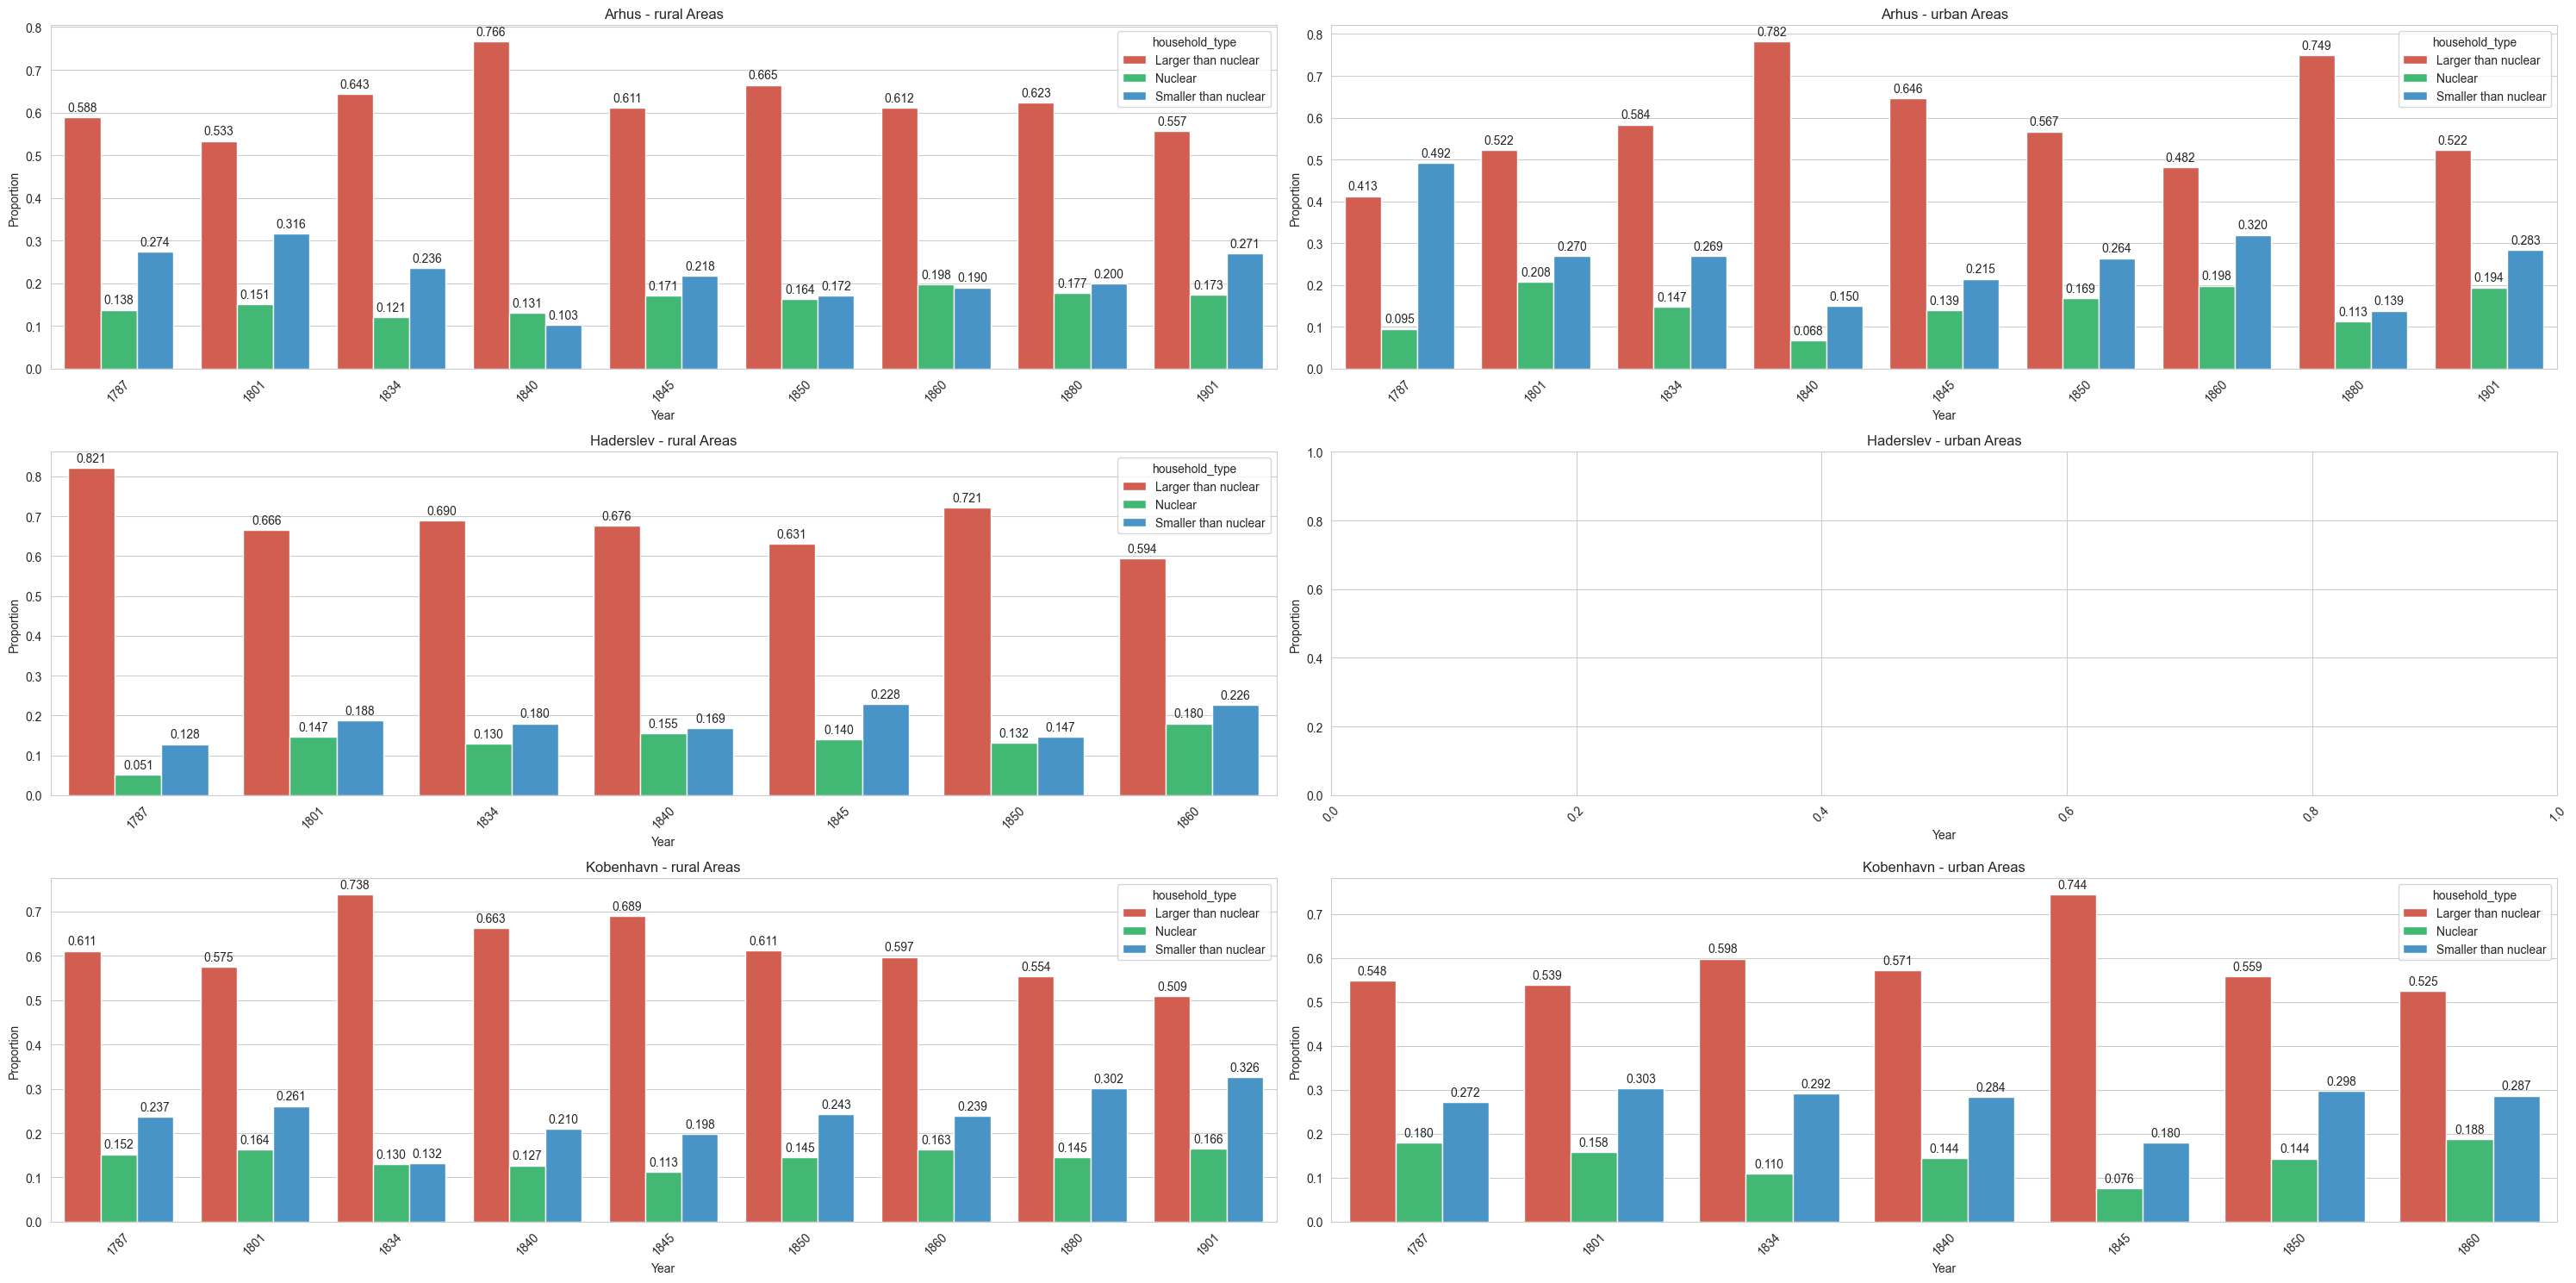

In [5]:
def create_temporal_summary_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates detailed summary statistics for household distributions by amt and year.
    
    Args:
        df (pd.DataFrame): DataFrame with household data
        
    Returns:
        pd.DataFrame: Summary statistics with temporal dimension
    """
    # Create multi-level summary statistics
    summary_stats = df.groupby(['amt', 'year', 'area_type']).agg({
        'total_members': ['count', 'mean', 'std', 'min', 'max'],
        'adult_males': ['mean', 'std'],
        'adult_females': ['mean', 'std'],
        'children': ['mean', 'std']
    }).round(2)
    
    # Flatten and rename columns for better readability
    summary_stats.columns = [
        'Number of households',
        'Mean household size',
        'Std household size',
        'Min household size',
        'Max household size',
        'Mean adult males',
        'Std adult males',
        'Mean adult females',
        'Std adult females',
        'Mean children',
        'Std children'
    ]
    
    # Reset index to make amt, year, and area_type visible columns
    summary_stats = summary_stats.reset_index()
    
    # Sort by amt, year, and area_type for better readability
    summary_stats = summary_stats.sort_values(['amt', 'year', 'area_type'])
    
    # Add some derived statistics
    summary_stats['Adults per household'] = (
        summary_stats['Mean adult males'] + summary_stats['Mean adult females']
    ).round(2)
    
    summary_stats['Children to adults ratio'] = (
        summary_stats['Mean children'] / 
        (summary_stats['Mean adult males'] + summary_stats['Mean adult females'])
    ).round(2)
    
    # Reorder columns for better presentation
    column_order = [
        'amt', 'year', 'area_type',
        'Number of households',
        'Mean household size',
        'Std household size',
        'Min household size',
        'Max household size',
        'Adults per household',
        'Mean adult males',
        'Mean adult females',
        'Mean children',
        'Children to adults ratio',
        'Std adult males',
        'Std adult females',
        'Std children'
    ]
    
    summary_stats = summary_stats[column_order]
    
    return summary_stats

def calculate_household_type_proportions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the proportion of each household type by year, amt, and area type.
    
    Args:
        df (pd.DataFrame): DataFrame with household classifications
        
    Returns:
        pd.DataFrame: DataFrame with proportions
    """
    # Calculate proportions with area_type included
    proportions = df.groupby(
        ['year', 'amt', 'area_type', 'household_type']
    ).size().reset_index()
    proportions.columns = ['year', 'amt', 'area_type', 'household_type', 'count']
    
    # Calculate total households for each group
    totals = df.groupby(['year', 'amt', 'area_type']).size().reset_index()
    totals.columns = ['year', 'amt', 'area_type', 'total']
    
    # Merge and calculate proportions
    proportions = proportions.merge(
        totals, 
        on=['year', 'amt', 'area_type']
    )
    proportions['proportion'] = proportions['count'] / proportions['total']
    
    return proportions

def display_formatted_statistics(stats_df: pd.DataFrame) -> None:
    """
    Displays the summary statistics in a nicely formatted way for each amt and area type.
    
    Args:
        stats_df (pd.DataFrame): DataFrame with summary statistics
    """
    # For each amt, display its statistics
    for amt in stats_df['amt'].unique():
        print(f"\n{'='*80}")
        print(f"Summary Statistics for {amt}")
        print('='*80)
        
        for area_type in sorted(stats_df['area_type'].unique()):
            print(f"\n{area_type} Areas")
            print('-'*40)
            
            area_stats = stats_df[
                (stats_df['amt'] == amt) & 
                (stats_df['area_type'] == area_type)
            ].copy()
            
            # Drop the amt and area_type columns for cleaner display
            area_stats = area_stats.drop(['amt', 'area_type'], axis=1)
            
            # Set year as index for cleaner display
            area_stats = area_stats.set_index('year')
            
            # Display with pandas styling
            display(area_stats.style
                   .format({col: '{:.2f}' for col in area_stats.columns if 'Number' not in col})
                   .background_gradient(subset=['Mean household size', 'Adults per household', 
                                             'Mean children', 'Children to adults ratio'])
                   .set_caption(f"Temporal Summary Statistics for {area_type} Areas in {amt}"))

def analyze_households_temporal(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Performs complete household analysis using existing area_type classification.
    
    Args:
        df (pd.DataFrame): Input census data with area_type column
        
    Returns:
        pd.DataFrame: Summary statistics
    """
    # Classify households and calculate proportions
    household_data = classify_household_types(df)
    proportions_data = calculate_household_type_proportions(household_data)
    
    # Create and display temporal summary statistics
    summary_stats = create_temporal_summary_statistics(household_data)
    display_formatted_statistics(summary_stats)
    
    # Create plots
    plot_household_types(proportions_data)
    
    return summary_stats

def classify_household_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Classifies households into three categories using existing area_type.
    
    Args:
        df (pd.DataFrame): Input DataFrame with census data
        
    Returns:
        pd.DataFrame: DataFrame with household classifications
    """
    # Create unique household identifier
    df['unique_household_id'] = (
        df['household_id'].astype(str) + '_' + 
        df['amt'] + '_' + 
        df['year'].astype(str)
    )
    
    # Convert age to numeric
    df['age_full_years'] = pd.to_numeric(df['age_full_years'], errors='coerce')
    
    # Create household composition summary
    household_summary = df.groupby('unique_household_id').agg({
        'amt': 'first',
        'year': 'first',
        'area_type': 'first',
        'parish': 'first'
    }).reset_index()
    
    # Count household members by type
    adult_males = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'm')
    ].groupby('unique_household_id').size()
    
    adult_females = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'k')
    ].groupby('unique_household_id').size()
    
    children = df[
        df['age_full_years'] < 18
    ].groupby('unique_household_id').size()
    
    total_members = df.groupby('unique_household_id').size()
    
    # Add counts to summary
    household_summary['adult_males'] = household_summary['unique_household_id'].map(adult_males).fillna(0)
    household_summary['adult_females'] = household_summary['unique_household_id'].map(adult_females).fillna(0)
    household_summary['children'] = household_summary['unique_household_id'].map(children).fillna(0)
    household_summary['total_members'] = household_summary['unique_household_id'].map(total_members)
    
    # Classify households
    nuclear_condition = (
        (household_summary['adult_males'] == 1) & 
        (household_summary['adult_females'] == 1) & 
        (household_summary['children'].between(1, 2))
    )
    
    larger_condition = (
        (household_summary['total_members'] > 4) |
        (household_summary['adult_males'] + household_summary['adult_females'] > 2) |
        (household_summary['children'] > 2)
    )
    
    # Apply classifications
    household_summary['household_type'] = 'Smaller than nuclear'
    household_summary.loc[nuclear_condition, 'household_type'] = 'Nuclear'
    household_summary.loc[larger_condition & ~nuclear_condition, 'household_type'] = 'Larger than nuclear'
    
    return household_summary

def plot_household_types(proportions: pd.DataFrame) -> None:
    """
    Creates plots showing household type proportions by amt and area type.
    
    Args:
        proportions (pd.DataFrame): DataFrame with household type proportions
    """
    # Create a subplot for each amt
    amts = sorted(proportions['amt'].unique())
    area_types = sorted(proportions['area_type'].unique())
    
    fig, axes = plt.subplots(
        len(amts), 
        len(area_types), 
        figsize=(15 * len(area_types), 5 * len(amts))
    )
    
    # Adjust axes for single row/column cases
    if len(amts) == 1:
        axes = axes.reshape(1, -1)
    if len(area_types) == 1:
        axes = axes.reshape(-1, 1)
    
    colors = {
        'Nuclear': '#2ecc71', 
        'Larger than nuclear': '#e74c3c', 
        'Smaller than nuclear': '#3498db'
    }
    
    for i, amt in enumerate(amts):
        for j, area_type in enumerate(area_types):
            data = proportions[
                (proportions['amt'] == amt) & 
                (proportions['area_type'] == area_type)
            ]
            
            # Create grouped bar plot
            sns.barplot(
                data=data,
                x='year',
                y='proportion',
                hue='household_type',
                palette=colors,
                ax=axes[i, j]
            )
            
            # Customize plot
            axes[i, j].set_title(f'{amt} - {area_type} Areas')
            axes[i, j].set_xlabel('Year')
            axes[i, j].set_ylabel('Proportion')
            axes[i, j].tick_params(axis='x', rotation=45)
            
            # Add value labels
            for container in axes[i, j].containers:
                axes[i, j].bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()

# Example usage:
analyze_households_temporal(df_raw)

As can be seen from the above grafs, the proportion of nuclear families, as 


Specifically for copenhagen, the changes in the amount of nuclear families we see from 1845 -> can be explained with the abolation of the mideval walls surrounding copenhagen, therby effectivly allowing the city to expand further and maybe incentivising people to seek residence further out. 

## Section 3: Occopation analysis

In [6]:
def analyze_nuclear_family_occupations(
    df: pd.DataFrame,
    urban_parishes: List[str],
    top_n: int = 10,
    figsize: Tuple[int, int] = (10, 6)
) -> Tuple[Dict[str, pd.DataFrame], None]:
    """
    Analyzes occupations in nuclear families with urban/rural distinction.
    
    Args:
        df (pd.DataFrame): Raw census data
        urban_parishes (List[str]): List of parishes considered urban
        top_n (int): Number of top occupations to show in visualization
        figsize (Tuple[int, int]): Size of individual plots
        
    Returns:
        Tuple[Dict[str, pd.DataFrame], None]: Dictionary of summary DataFrames and None (plots are displayed)
    """
    # First, identify nuclear families using existing function
    df_with_urban = add_urban_classification(df, urban_parishes)
    household_data = classify_household_types(df_with_urban)
    
    # Get nuclear family household IDs
    nuclear_households = household_data[
        household_data['household_type'] == 'Nuclear'
    ]['unique_household_id'].unique()
    
    # Filter original data for nuclear families
    nuclear_df = df_with_urban[
        df_with_urban['unique_household_id'].isin(nuclear_households)
    ].copy()
    
    # Create occupation analysis by amt, gender and area type
    def analyze_occupations(data: pd.DataFrame) -> pd.DataFrame:
        """Helper function to analyze occupations in a dataset."""
        if len(data) == 0:
            return pd.DataFrame(columns=['Occupation', 'Households', 'Individuals', 'Percent_of_Total'])
            
        occupation_stats = data.groupby('Erhverv').agg({
            'unique_household_id': 'nunique',  # Count unique households
            'sex': 'count'  # Count total individuals
        }).reset_index()
        
        occupation_stats.columns = ['Occupation', 'Households', 'Individuals']
        occupation_stats['Percent_of_Total'] = (
            occupation_stats['Individuals'] / len(data) * 100
        ).round(2)
        
        return occupation_stats.sort_values('Individuals', ascending=False)
    
    # Initialize results dictionary
    results = {}
    
    # Analyze for each combination of amt, area type and gender
    for amt in df['amt'].unique():
        amt_results = {}
        amt_data = nuclear_df[nuclear_df['amt'] == amt]
        
        for area in ['urban', 'rural']:
            for gender in ['m', 'k']:
                subset = amt_data[
                    (amt_data['area_type'] == area) & 
                    (amt_data['sex'] == gender) &
                    (amt_data['age_full_years'] >= 18)  # Adults only
                ]
                
                key = f"{area}_{gender}"
                amt_results[key] = analyze_occupations(subset)
        
        results[amt] = amt_results
    
    # Create visualizations with separate plots for each amt
    plot_occupation_analysis_by_amt(results, top_n, figsize)
    
    # Create detailed statistics
    detailed_stats = create_detailed_occupation_stats(nuclear_df)
    
    return results, detailed_stats

def plot_occupation_analysis_by_amt(
    results: Dict[str, Dict[str, pd.DataFrame]],
    top_n: int,
    figsize: Tuple[int, int] = (10, 6)
) -> None:
    """
    Creates separate visualizations for each amt.
    
    Args:
        results (Dict[str, Dict[str, pd.DataFrame]]): Dictionary of occupation analysis results by amt
        top_n (int): Number of top occupations to show
        figsize (Tuple[int, int]): Size of individual plots
    """
    area_gender_combinations = {
        (0, 0): ('urban', 'm', 'urban Male Occupations'),
        (0, 1): ('urban', 'k', 'urban Female Occupations'),
        (1, 0): ('rural', 'm', 'rural Male Occupations'),
        (1, 1): ('rural', 'k', 'rural Female Occupations')
    }
    
    # Plot for each amt separately
    for amt in results.keys():
        print(f"\n{'='*50}")
        print(f"Occupation Analysis for {amt}")
        print('='*50)
        
        # Create figure for this amt
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        for (i, j), (area, gender, title) in area_gender_combinations.items():
            key = f"{area}_{gender}"
            data = results[amt][key]
            
            if len(data) > 0:  # Only plot if there's data
                data = data.head(top_n)
                
                # Create bar plot
                sns.barplot(
                    data=data,
                    x='Percent_of_Total',
                    y='Occupation',
                    ax=axes[i, j]
                )
                
                # Customize subplot
                axes[i, j].set_title(f"{title}\n{amt}", fontsize=10)
                axes[i, j].set_xlabel('Percentage of Total', fontsize=8)
                axes[i, j].set_ylabel('Occupation', fontsize=8)
                axes[i, j].tick_params(labelsize=7)
                
                # Add value labels
                for idx, row in data.iterrows():
                    axes[i, j].text(
                        row['Percent_of_Total'],
                        idx,
                        f"{row['Percent_of_Total']}% ({row['Individuals']})",
                        va='center',
                        fontsize=7
                    )
            else:
                axes[i, j].text(
                    0.5, 0.5, 
                    'No data available',
                    ha='center', va='center'
                )
                axes[i, j].set_title(f"{title}\n{amt}", fontsize=10)
        
        plt.tight_layout()
        plt.show()  # Display plot for this amt
        plt.close()  # Close the figure to free memory

def display_occupation_trends_by_amt(
    df: pd.DataFrame,
    urban_parishes: List[str],
    max_rows: int = 15
) -> None:
    """
    Display temporal trends in occupations for nuclear families by amt.
    
    Args:
        df (pd.DataFrame): Raw census data
        urban_parishes (List[str]): List of parishes considered urban
        max_rows (int): Maximum number of rows to display at once
    """
    # Get nuclear family data
    df_with_urban = add_urban_classification(df, urban_parishes)
    household_data = classify_household_types(df_with_urban)
    nuclear_households = household_data[
        household_data['household_type'] == 'Nuclear'
    ]['unique_household_id'].unique()
    nuclear_df = df_with_urban[
        df_with_urban['unique_household_id'].isin(nuclear_households)
    ].copy()
    
    # Create temporal analysis
    stats = create_detailed_occupation_stats(nuclear_df)
    
    # Display formatted statistics by amt
    for amt in sorted(df['amt'].unique()):
        print(f"\n{'='*80}")
        print(f"Occupation Trends in {amt}")
        print('='*80)
        
        for area in ['urben', 'rural']:
            print(f"\n{area} Areas in {amt}")
            print('-'*40)
            
            area_stats = stats[
                (stats['Area'] == area) & 
                (nuclear_df['amt'] == amt)
            ].copy()
            
            if len(area_stats) > 0:
                area_stats = area_stats.sort_values(['Year', 'Gender'])
                
                # Split into chunks if necessary
                total_rows = len(area_stats)
                for i in range(0, total_rows, max_rows):
                    chunk = area_stats.iloc[i:min(i+max_rows, total_rows)]
                    
                    if i > 0:
                        print(f"\nContinued... (Showing rows {i+1}-{min(i+max_rows, total_rows)} of {total_rows})")
                    
                    display(chunk.style
                           .set_properties(**{'text-align': 'left'})
                           .set_table_styles([
                               {'selector': 'th', 'props': [('text-align', 'left')]},
                               {'selector': 'td', 'props': [('text-align', 'left')]}
                           ])
                           .set_caption(f"Temporal Occupation Trends for {area} Areas in {amt}"))
            else:
                print(f"No data available for {area} areas in {amt}")

# Example usage:
results, detailed_stats = analyze_nuclear_family_occupations(
     df_raw, 
     urban_parishes,
     top_n=8,
     figsize=(2, 1)
 )
display_occupation_trends_by_amt(df_raw, urban_parishes, max_rows=15)

NameError: name 'add_urban_classification' is not defined

## Tests

Analyzing nuclear family patterns...


/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(



Generating visualizations...


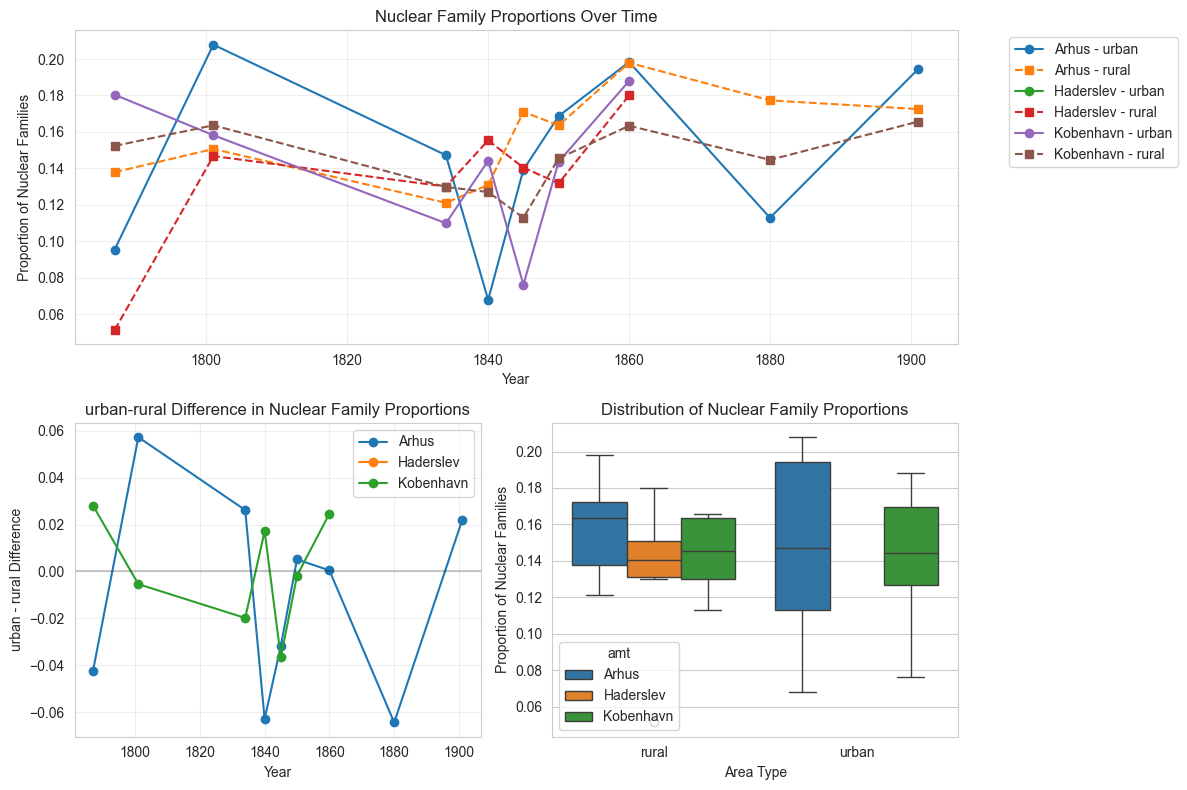


Calculating statistical comparisons...

Statistical Comparison of urban and rural Areas:


/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:153: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(urban_props, rural_props)


,amt,urban_mean,rural_mean,mean_difference,urban_std,rural_std,t_statistic,p_value,cohens_d
0,Arhus,0.148,0.158,-0.010,0.049,0.025,-0.551,0.589,-0.260
1,Haderslev,nan,0.134,nan,nan,0.040,nan,nan,nan
2,Kobenhavn,0.143,0.145,-0.002,0.039,0.019,-0.139,0.891,-0.067



Analyzing temporal changes...

Temporal Changes in Nuclear Family Proportions:


/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(


,amt,area_type,start_year,end_year,start_proportion,end_proportion,absolute_change,percent_change
0,Arhus,rural,1787,1901,0.138,0.173,0.035,25.127
1,Arhus,urban,1787,1901,0.095,0.194,0.099,103.697
2,Haderslev,rural,1787,1860,0.051,0.180,0.129,251.138
3,Kobenhavn,rural,1787,1901,0.152,0.166,0.013,8.743
4,Kobenhavn,urban,1787,1860,0.180,0.188,0.008,4.209


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, Tuple
import numpy as np
from scipy import stats

def preprocess_raw_data(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses raw census data for nuclear family analysis.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        pd.DataFrame: Processed data with household classifications
    """
    # Classify households
    household_data = classify_household_types(df_raw)
    
    # Calculate proportions
    proportions_data = calculate_household_type_proportions(household_data)
    
    return household_data

def analyze_nuclear_family_trends(df_raw: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Analyzes nuclear family trends with focus on urban/rural differences.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary containing different trend analyses
    """
    # Preprocess raw data
    household_data = preprocess_raw_data(df_raw)
    
    # Get only nuclear families
    nuclear_data = household_data[household_data['household_type'] == 'Nuclear'].copy()
    
    # Calculate proportions by year, amt, and area_type
    def calculate_props(data):
        total = len(data)
        return pd.Series({
            'count': total,
            'prop_nuclear': total / len(household_data[
                (household_data['year'] == data['year'].iloc[0]) &
                (household_data['amt'] == data['amt'].iloc[0]) &
                (household_data['area_type'] == data['area_type'].iloc[0])
            ])
        })
    
    # Group and calculate
    trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(
        calculate_props
    ).reset_index()
    
    # Calculate urban-rural difference for each amt and year
    pivot_props = trends.pivot_table(
        index=['year', 'amt'],
        columns='area_type',
        values='prop_nuclear'
    ).reset_index()
    
    pivot_props['urban_rural_diff'] = pivot_props['urban'] - pivot_props['rural']
    
    return {
        'trends': trends,
        'urban_rural_diff': pivot_props
    }

def plot_nuclear_family_trends(results: Dict[str, pd.DataFrame]) -> None:
    """
    Creates visualizations for nuclear family trends.
    
    Args:
        results (Dict[str, pd.DataFrame]): Results from analyze_nuclear_family_trends
    """
    trends = results['trends']
    urban_rural_diff = results['urban_rural_diff']
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2)
    
    # 1. Time series of proportions by area type for each amt
    ax1 = fig.add_subplot(gs[0, :])
    for amt in trends['amt'].unique():
        amt_data = trends[trends['amt'] == amt]
        
        # Plot urban
        urban_data = amt_data[amt_data['area_type'] == 'urban']
        ax1.plot(urban_data['year'], urban_data['prop_nuclear'], 
                marker='o', linestyle='-', label=f'{amt} - urban')
        
        # Plot rural
        rural_data = amt_data[amt_data['area_type'] == 'rural']
        ax1.plot(rural_data['year'], rural_data['prop_nuclear'], 
                marker='s', linestyle='--', label=f'{amt} - rural')
    
    ax1.set_title('Nuclear Family Proportions Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Proportion of Nuclear Families')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. urban-rural difference over time
    ax2 = fig.add_subplot(gs[1, 0])
    for amt in urban_rural_diff['amt'].unique():
        amt_data = urban_rural_diff[urban_rural_diff['amt'] == amt]
        ax2.plot(amt_data['year'], amt_data['urban_rural_diff'], 
                marker='o', label=amt)
    
    ax2.set_title('urban-rural Difference in Nuclear Family Proportions')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('urban - rural Difference')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    
    # 3. Box plot of proportions by area type
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=trends, x='area_type', y='prop_nuclear', hue='amt', ax=ax3)
    ax3.set_title('Distribution of Nuclear Family Proportions')
    ax3.set_xlabel('Area Type')
    ax3.set_ylabel('Proportion of Nuclear Families')
    
    plt.tight_layout()
    plt.show()

def calculate_urban_rural_statistics(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates statistical comparisons between urban and rural areas.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        pd.DataFrame: Statistical analysis results
    """
    results = analyze_nuclear_family_trends(df_raw)
    trends = results['trends']
    stats_results = []
    
    for amt in trends['amt'].unique():
        amt_data = trends[trends['amt'] == amt]
        
        urban_props = amt_data[amt_data['area_type'] == 'urban']['prop_nuclear']
        rural_props = amt_data[amt_data['area_type'] == 'rural']['prop_nuclear']
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(urban_props, rural_props)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((urban_props.var() + rural_props.var()) / 2)
        cohens_d = (urban_props.mean() - rural_props.mean()) / pooled_std
        
        stats_results.append({
            'amt': amt,
            'urban_mean': urban_props.mean(),
            'rural_mean': rural_props.mean(),
            'mean_difference': urban_props.mean() - rural_props.mean(),
            'urban_std': urban_props.std(),
            'rural_std': rural_props.std(),
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d
        })
    
    return pd.DataFrame(stats_results)

def analyze_temporal_changes(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes how nuclear family proportions changed over time.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        pd.DataFrame: Temporal change analysis
    """
    # Get preprocessed data
    results = analyze_nuclear_family_trends(df_raw)
    trends = results['trends']
    
    # Calculate changes over time
    temporal_changes = trends.groupby(['amt', 'area_type']).agg({
        'year': ['min', 'max'],
        'prop_nuclear': ['first', 'last']
    }).reset_index()
    
    # Flatten column names
    temporal_changes.columns = [
        'amt', 'area_type', 'start_year', 'end_year', 
        'start_proportion', 'end_proportion'
    ]
    
    # Calculate changes
    temporal_changes['absolute_change'] = (
        temporal_changes['end_proportion'] - temporal_changes['start_proportion']
    )
    temporal_changes['percent_change'] = (
        (temporal_changes['end_proportion'] / temporal_changes['start_proportion'] - 1) * 100
    )
    
    return temporal_changes

def run_urban_rural_analysis(df_raw: pd.DataFrame) -> None:
    """
    Runs complete urban/rural nuclear family analysis from raw data.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
    """
    print("Analyzing nuclear family patterns...")
    
    # Run main analysis
    results = analyze_nuclear_family_trends(df_raw)
    
    # Create visualizations
    print("\nGenerating visualizations...")
    plot_nuclear_family_trends(results)
    
    # Calculate and display statistics
    print("\nCalculating statistical comparisons...")
    stats = calculate_urban_rural_statistics(df_raw)
    print("\nStatistical Comparison of urban and rural Areas:")
    display(stats.style
           .format({col: '{:.3f}' for col in stats.columns if col != 'amt'})
           .background_gradient(subset=['mean_difference', 'cohens_d'])
           .set_caption("urban-rural Statistical Comparison"))
    
    # Analyze temporal changes
    print("\nAnalyzing temporal changes...")
    temporal_changes = analyze_temporal_changes(df_raw)
    print("\nTemporal Changes in Nuclear Family Proportions:")
    display(temporal_changes.style
           .format({col: '{:.3f}' for col in temporal_changes.columns 
                   if col not in ['amt', 'area_type', 'start_year', 'end_year']})
           .background_gradient(subset=['absolute_change', 'percent_change'])
           .set_caption("Temporal Changes Analysis"))

# Example usage:
run_urban_rural_analysis(df_raw)

In [20]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Dict, Tuple
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

def calculate_advanced_statistics(df_raw: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Calculates advanced statistical measures for nuclear family patterns.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary of various statistical analyses
    """
    # Get preprocessed data first
    results = analyze_nuclear_family_trends(df_raw)
    trends = results['trends']
    
    # Initialize results dictionary
    stat_results = {}
    
    # 1. Time Series Stationarity Test
    stationarity_results = []
    for amt in trends['amt'].unique():
        for area_type in trends['area_type'].unique():
            subset = trends[
                (trends['amt'] == amt) & 
                (trends['area_type'] == area_type)
            ]['prop_nuclear']
            
            if len(subset) > 3:  # Need enough data points for test
                adf_test = adfuller(subset)
                stationarity_results.append({
                    'amt': amt,
                    'area_type': area_type,
                    'adf_statistic': adf_test[0],
                    'p_value': adf_test[1],
                    'is_stationary': adf_test[1] < 0.05
                })
    
    stat_results['stationarity'] = pd.DataFrame(stationarity_results)
    
    # 2. Proportion Test Between Time Periods
    proportion_test_results = []
    for amt in trends['amt'].unique():
        for area_type in trends['area_type'].unique():
            subset = trends[
                (trends['amt'] == amt) & 
                (trends['area_type'] == area_type)
            ].sort_values('year')
            
            if len(subset) >= 2:
                # Compare first and last time periods
                first_period = subset.iloc[0]
                last_period = subset.iloc[-1]
                
                # Prepare data for proportion test
                count = np.array([first_period['count'], last_period['count']])
                nobs = np.array([
                    first_period['count'] / first_period['prop_nuclear'],
                    last_period['count'] / last_period['prop_nuclear']
                ])
                
                # Perform test
                z_stat, p_val = proportions_ztest(count, nobs)
                
                proportion_test_results.append({
                    'amt': amt,
                    'area_type': area_type,
                    'start_year': subset['year'].iloc[0],
                    'end_year': subset['year'].iloc[-1],
                    'z_statistic': z_stat,
                    'p_value': p_val,
                    'significant_change': p_val < 0.05
                })
    
    stat_results['proportion_tests'] = pd.DataFrame(proportion_test_results)
    
    # 3. Trend Analysis using Linear Regression
    trend_results = []
    for amt in trends['amt'].unique():
        for area_type in trends['area_type'].unique():
            subset = trends[
                (trends['amt'] == amt) & 
                (trends['area_type'] == area_type)
            ].sort_values('year')
            
            if len(subset) > 2:
                # Prepare data for regression
                X = sm.add_constant(subset['year'] - subset['year'].min())
                y = subset['prop_nuclear']
                
                # Fit regression
                model = sm.OLS(y, X).fit()
                
                trend_results.append({
                    'amt': amt,
                    'area_type': area_type,
                    'slope': model.params[1],
                    'slope_p_value': model.pvalues[1],
                    'r_squared': model.rsquared,
                    'trend_direction': 'Increasing' if model.params[1] > 0 else 'Decreasing',
                    'significant_trend': model.pvalues[1] < 0.05
                })
    
    stat_results['trends'] = pd.DataFrame(trend_results)
    
    # 4. Volatility Analysis
    volatility_results = []
    for amt in trends['amt'].unique():
        for area_type in trends['area_type'].unique():
            subset = trends[
                (trends['amt'] == amt) & 
                (trends['area_type'] == area_type)
            ]
            
            if len(subset) > 1:
                # Calculate year-over-year changes
                prop_changes = subset.sort_values('year')['prop_nuclear'].pct_change()
                
                volatility_results.append({
                    'amt': amt,
                    'area_type': area_type,
                    'mean_change': prop_changes.mean(),
                    'volatility': prop_changes.std(),
                    'max_increase': prop_changes.max(),
                    'max_decrease': prop_changes.min(),
                    'change_range': prop_changes.max() - prop_changes.min()
                })
    
    stat_results['volatility'] = pd.DataFrame(volatility_results)
    
    return stat_results

def display_advanced_statistics(stat_results: Dict[str, pd.DataFrame]) -> None:
    """
    Displays the advanced statistical analyses in a formatted way.
    
    Args:
        stat_results (Dict[str, pd.DataFrame]): Results from calculate_advanced_statistics
    """
    # 1. Stationarity Results
    print("\nTime Series Stationarity Analysis:")
    print("="*80)
    print("Tests whether the proportion of nuclear families shows stable patterns over time")
    display(stat_results['stationarity'].style
           .format({
               'adf_statistic': '{:.3f}',
               'p_value': '{:.3f}'
           })
           .background_gradient(subset=['adf_statistic'])
           .set_caption("Stationarity Test Results"))
    
    # 2. Proportion Test Results
    print("\nProportion Test Analysis (First vs Last Period):")
    print("="*80)
    print("Compares if the change in proportions between first and last periods is statistically significant")
    display(stat_results['proportion_tests'].style
           .format({
               'z_statistic': '{:.3f}',
               'p_value': '{:.3f}'
           })
           .background_gradient(subset=['z_statistic'])
           .set_caption("Proportion Test Results"))
    
    # 3. Trend Analysis
    print("\nTrend Analysis Results:")
    print("="*80)
    print("Analyzes the direction and significance of trends in nuclear family proportions")
    display(stat_results['trends'].style
           .format({
               'slope': '{:.5f}',
               'slope_p_value': '{:.3f}',
               'r_squared': '{:.3f}'
           })
           .background_gradient(subset=['slope', 'r_squared'])
           .set_caption("Trend Analysis Results"))
    
    # 4. Volatility Analysis
    print("\nVolatility Analysis Results:")
    print("="*80)
    print("Measures the stability and magnitude of changes in nuclear family proportions")
    display(stat_results['volatility'].style
           .format({
               'mean_change': '{:.3f}',
               'volatility': '{:.3f}',
               'max_increase': '{:.3f}',
               'max_decrease': '{:.3f}',
               'change_range': '{:.3f}'
           })
           .background_gradient(subset=['volatility', 'change_range'])
           .set_caption("Volatility Analysis Results"))

def run_advanced_analysis(df_raw: pd.DataFrame) -> None:
    """
    Runs the advanced statistical analysis on the raw data.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
    """
    print("Calculating advanced statistical measures...")
    stat_results = calculate_advanced_statistics(df_raw)
    
    print("\nDisplaying statistical analysis results...")
    display_advanced_statistics(stat_results)

# Example usage:
run_advanced_analysis(df_raw)

Calculating advanced statistical measures...

Displaying statistical analysis results...

Time Series Stationarity Analysis:
Tests whether the proportion of nuclear families shows stable patterns over time


/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/2654743194.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'slope': model.params[1],
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/2654743194.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

,amt,area_type,adf_statistic,p_value,is_stationary
0,Arhus,rural,-1.422,0.572,False
1,Arhus,urban,-3.334,0.013,True
2,Haderslev,rural,-4.411,0.000,True
3,Kobenhavn,rural,-1.652,0.456,False
4,Kobenhavn,urban,-2.002,0.286,False



Proportion Test Analysis (First vs Last Period):
Compares if the change in proportions between first and last periods is statistically significant


,amt,area_type,start_year,end_year,z_statistic,p_value,significant_change
0,Arhus,rural,1787,1901,-5.100,0.000,True
1,Arhus,urban,1787,1901,-8.287,0.000,True
2,Haderslev,rural,1787,1860,-2.091,0.036,True
3,Kobenhavn,rural,1787,1901,-4.090,0.000,True
4,Kobenhavn,urban,1787,1860,-1.283,0.200,False



Trend Analysis Results:
Analyzes the direction and significance of trends in nuclear family proportions


,amt,area_type,slope,slope_p_value,r_squared,trend_direction,significant_trend
0,Arhus,rural,0.00041,0.095,0.347,Increasing,False
1,Arhus,urban,0.00030,0.570,0.048,Increasing,False
2,Haderslev,rural,0.00111,0.054,0.557,Increasing,False
3,Kobenhavn,rural,0.00004,0.832,0.007,Increasing,False
4,Kobenhavn,urban,-0.00042,0.533,0.082,Decreasing,False



Volatility Analysis Results:
Measures the stability and magnitude of changes in nuclear family proportions


,amt,area_type,mean_change,volatility,max_increase,max_decrease,change_range
0,Arhus,rural,0.040,0.166,0.307,-0.196,0.503
1,Arhus,urban,0.260,0.667,1.178,-0.539,1.717
2,Haderslev,rural,0.359,0.761,1.862,-0.114,1.976
3,Kobenhavn,rural,0.022,0.165,0.289,-0.207,0.496
4,Kobenhavn,urban,0.101,0.500,0.886,-0.472,1.358


In [22]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import Dict, Tuple
import statsmodels.api as sm
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def calculate_specialized_statistics(df_raw: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Calculates specialized statistical measures for nuclear family patterns.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
        
    Returns:
        Dict[str, pd.DataFrame]: Dictionary of specialized statistical analyses
    """
    # Get preprocessed data
    results = analyze_nuclear_family_trends(df_raw)
    trends = results['trends']
    
    stat_results = {}
    
    # 1. Generational Turnover Analysis
    def calculate_turnover(df: pd.DataFrame) -> pd.DataFrame:
        """Analyzes changes between consecutive census years."""
        turnover_results = []
        
        for amt in df['amt'].unique():
            for area_type in df['area_type'].unique():
                subset = df[
                    (df['amt'] == amt) & 
                    (df['area_type'] == area_type)
                ].sort_values('year')
                
                if len(subset) > 1:
                    # Calculate inter-census changes
                    changes = subset['prop_nuclear'].diff()
                    
                    turnover_results.append({
                        'amt': amt,
                        'area_type': area_type,
                        'mean_intercensus_change': changes.mean(),
                        'std_intercensus_change': changes.std(),
                        'positive_changes': (changes > 0).sum(),
                        'negative_changes': (changes < 0).sum(),
                        'stability_index': 1 - (abs(changes).mean() / subset['prop_nuclear'].mean())
                    })
        
        return pd.DataFrame(turnover_results)
    
    stat_results['generational_turnover'] = calculate_turnover(trends)
    
    # 2. Regional Convergence Analysis
    def calculate_convergence(df: pd.DataFrame) -> pd.DataFrame:
        """Analyzes whether regions become more similar over time."""
        convergence_results = []
        
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            
            # Calculate coefficient of variation for each area type
            for area_type in df['area_type'].unique():
                area_data = year_data[year_data['area_type'] == area_type]
                if len(area_data) > 1:
                    cv = area_data['prop_nuclear'].std() / area_data['prop_nuclear'].mean()
                    
                    convergence_results.append({
                        'year': year,
                        'area_type': area_type,
                        'coefficient_of_variation': cv,
                        'max_diff': area_data['prop_nuclear'].max() - area_data['prop_nuclear'].min(),
                        'n_regions': len(area_data)
                    })
        
        return pd.DataFrame(convergence_results)
    
    stat_results['regional_convergence'] = calculate_convergence(trends)
    
    # 3. Spatial Autocorrelation Proxy
    def calculate_spatial_patterns(df: pd.DataFrame) -> pd.DataFrame:
        """Analyzes similarities between neighboring regions."""
        spatial_results = []
        
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            
            for area_type in df['area_type'].unique():
                area_data = year_data[year_data['area_type'] == area_type]
                
                if len(area_data) > 1:
                    # Calculate pairwise differences
                    props = area_data.pivot(
                        index='amt', 
                        columns='area_type', 
                        values='prop_nuclear'
                    )
                    
                    dist_matrix = pdist(props.values.reshape(-1, 1))
                    
                    spatial_results.append({
                        'year': year,
                        'area_type': area_type,
                        'mean_difference': np.mean(dist_matrix),
                        'max_difference': np.max(dist_matrix),
                        'similarity_index': 1 - (np.mean(dist_matrix) / np.max(dist_matrix))
                    })
        
        return pd.DataFrame(spatial_results)
    
    stat_results['spatial_patterns'] = calculate_spatial_patterns(trends)
    
    # 4. Structural Break Analysis
    def analyze_structural_breaks(df: pd.DataFrame) -> pd.DataFrame:
        """Identifies potential structural breaks in the time series."""
        break_results = []
        
        for amt in df['amt'].unique():
            for area_type in df['area_type'].unique():
                subset = df[
                    (df['amt'] == amt) & 
                    (df['area_type'] == area_type)
                ].sort_values('year')
                
                if len(subset) > 4:  # Need enough data points
                    # Use rolling windows to identify significant changes
                    rolling_mean = subset['prop_nuclear'].rolling(window=2).mean()
                    rolling_std = subset['prop_nuclear'].rolling(window=2).std()
                    
                    # Identify breaks where change exceeds 2 standard deviations
                    breaks = np.where(
                        abs(subset['prop_nuclear'] - rolling_mean) > 2 * rolling_std
                    )[0]
                    
                    break_results.append({
                        'amt': amt,
                        'area_type': area_type,
                        'n_structural_breaks': len(breaks),
                        'break_years': ', '.join(map(str, subset.iloc[breaks]['year'].values)),
                        'mean_break_magnitude': np.mean(
                            abs(subset['prop_nuclear'].diff().iloc[breaks])
                        ) if len(breaks) > 0 else 0
                    })
        
        return pd.DataFrame(break_results)
    
    stat_results['structural_breaks'] = analyze_structural_breaks(trends)
    
    # 5. Seasonal Decomposition (if multiple censuses within years)
    # This would be relevant if you have multiple censuses within years
    
    return stat_results

def display_specialized_statistics(stat_results: Dict[str, pd.DataFrame]) -> None:
    """
    Displays the specialized statistical analyses in a formatted way.
    
    Args:
        stat_results (Dict[str, pd.DataFrame]): Results from calculate_specialized_statistics
    """
    # 1. Generational Turnover Results
    print("\nGenerational Turnover Analysis:")
    print("="*80)
    print("Analyzes the stability and patterns of change between consecutive census years")
    display(stat_results['generational_turnover'].style
           .format({col: '{:.3f}' for col in stat_results['generational_turnover'].columns 
                   if col not in ['amt', 'area_type']})
           .background_gradient(subset=['stability_index'])
           .set_caption("Generational Turnover Analysis"))
    
    # 2. Regional Convergence Results
    print("\nRegional Convergence Analysis:")
    print("="*80)
    print("Shows whether regions become more similar over time")
    display(stat_results['regional_convergence'].style
           .format({col: '{:.3f}' for col in stat_results['regional_convergence'].columns 
                   if col not in ['year', 'area_type', 'n_regions']})
           .background_gradient(subset=['coefficient_of_variation'])
           .set_caption("Regional Convergence Analysis"))
    
    # 3. Spatial Pattern Results
    print("\nSpatial Pattern Analysis:")
    print("="*80)
    print("Examines similarities between regions")
    display(stat_results['spatial_patterns'].style
           .format({col: '{:.3f}' for col in stat_results['spatial_patterns'].columns 
                   if col not in ['year', 'area_type']})
           .background_gradient(subset=['similarity_index'])
           .set_caption("Spatial Pattern Analysis"))
    
    # 4. Structural Break Results
    print("\nStructural Break Analysis:")
    print("="*80)
    print("Identifies significant changes in patterns over time")
    display(stat_results['structural_breaks'].style
           .format({col: '{:.3f}' for col in stat_results['structural_breaks'].columns 
                   if col not in ['amt', 'area_type', 'break_years', 'n_structural_breaks']})
           .background_gradient(subset=['mean_break_magnitude'])
           .set_caption("Structural Break Analysis"))

def run_specialized_analysis(df_raw: pd.DataFrame) -> None:
    """
    Runs the specialized statistical analysis on the raw data.
    
    Args:
        df_raw (pd.DataFrame): Raw census data
    """
    print("Calculating specialized statistical measures...")
    stat_results = calculate_specialized_statistics(df_raw)
    
    print("\nDisplaying specialized analysis results...")
    display_specialized_statistics(stat_results)

# Example usage:
run_specialized_analysis(df_raw)

Calculating specialized statistical measures...

Displaying specialized analysis results...

Generational Turnover Analysis:
Analyzes the stability and patterns of change between consecutive census years


/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_81304/1123413675.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = nuclear_data.groupby(['year', 'amt', 'area_type']).apply(


,amt,area_type,mean_intercensus_change,std_intercensus_change,positive_changes,negative_changes,stability_index
0,Arhus,rural,0.004,0.025,4.000,4.000,0.874
1,Arhus,urban,0.012,0.078,5.000,3.000,0.535
2,Haderslev,rural,0.021,0.045,3.000,3.000,0.739
3,Kobenhavn,rural,0.002,0.023,4.000,4.000,0.869
4,Kobenhavn,urban,0.001,0.055,3.000,3.000,0.668



Regional Convergence Analysis:
Shows whether regions become more similar over time


,year,area_type,coefficient_of_variation,max_diff,n_regions
0,1787,rural,0.480,0.101,3
1,1787,urban,0.436,0.085,2
2,1801,rural,0.058,0.017,3
3,1801,urban,0.192,0.050,2
4,1834,rural,0.040,0.009,3
5,1834,urban,0.205,0.037,2
6,1840,rural,0.112,0.028,3
7,1840,urban,0.509,0.076,2
8,1845,rural,0.206,0.058,3
9,1845,urban,0.414,0.063,2



Spatial Pattern Analysis:
Examines similarities between regions


,year,area_type,mean_difference,max_difference,similarity_index
0,1787,rural,0.067,0.101,0.333
1,1787,urban,0.085,0.085,0.000
2,1801,rural,0.011,0.017,0.333
3,1801,urban,0.050,0.050,0.000
4,1834,rural,0.006,0.009,0.333
5,1834,urban,0.037,0.037,0.000
6,1840,rural,0.019,0.028,0.333
7,1840,urban,0.076,0.076,0.000
8,1845,rural,0.039,0.058,0.333
9,1845,urban,0.063,0.063,0.000



Structural Break Analysis:
Identifies significant changes in patterns over time


,amt,area_type,n_structural_breaks,break_years,mean_break_magnitude
0,Arhus,rural,0,,0.000
1,Arhus,urban,0,,0.000
2,Haderslev,rural,0,,0.000
3,Kobenhavn,rural,0,,0.000
4,Kobenhavn,urban,0,,0.000
